<div style="text-align: center; font-weight: bold; font-size: 300%">Projet INF473-V</div>                                                        <br /> 
<div style="text-align: center; font-weight: bold; font-size: 180%">Processing - ResNet-50 - 3 classes </div>                                                        <br />  
<div style="text-align: center; font-size: 150%">École Polytechnique, juin 2020</div><br />  
<div style="text-align: center; font-size: 120%">Youssef Allouah et Paul Calot</div>

In [0]:
# libraries
import pandas as pd # to read csv files
import numpy as np
import imageio # to read imported img
import torch
from torchvision import datasets, transforms # to transforms to tensor etc. and create our own datasets
import matplotlib.pyplot as plt # to show img
import tqdm
from google.colab import files
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/projet - MODAL/datasets/"


Mounted at /content/gdrive


https://drive.google.com/drive/folders/1xTUMQhu-JbkTSriWoLJxmJXrj5jnrKym?usp=sharing 

In [0]:
# first training - 3 classes
training_set_3classes = torch.load(root_dir + "training_set_3classes")
testing_set_3classes = torch.load(root_dir + "testing_set_3classes")


# second training - 4 classes -> to load later if not enough memory
training_set = torch.load(root_dir + "dataset_8")
testing_set = torch.load(root_dir + "testing_dataset_1400")

In [0]:
# print proportion
train_size = len(training_set_3classes)
test_size = len(testing_set_3classes)
per_train = [0,0,0]
per_test = [0,0,0]
for k in range(train_size):
  per_train[int(training_set_3classes[k][1].item())]+=1

for k in range(test_size):
  per_test[int(testing_set_3classes[k][1].item())]+=1

for k in range(3):
  per_train[k] = round(per_train[k]/train_size,4)
  per_test[k] = round(per_test[k]/test_size,4)

Size of the training dataset :3996
Size of the testing dataset :398


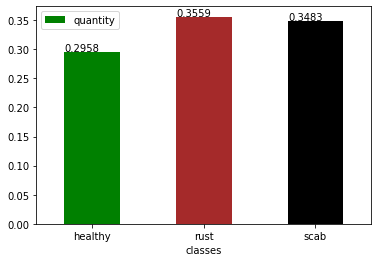

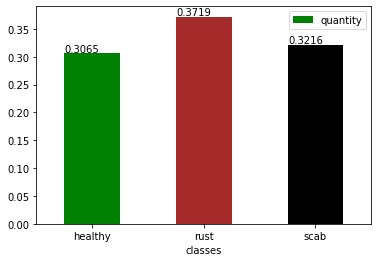

In [5]:


df = pd.DataFrame({'classes':['healthy', 'rust','scab'], 'quantity':per_train})
ax1 = df.plot.bar(x='classes', y='quantity', color = ['g', 'brown', 'k'], rot = 0)
fig1 = ax1.get_figure()
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height() * 1.005))

df = pd.DataFrame({'classes':['healthy', 'rust','scab'], 'quantity':per_test})
ax2 = df.plot.bar(x='classes', y='quantity', color = ['g', 'brown', 'k'], rot = 0)
fig2 = ax2.get_figure()

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.006))

fig1.savefig('train_repartition.png', dpi=400)
fig2.savefig('test_repartition.png', dpi=400)

print("Size of the training dataset :" + str(train_size))
print("Size of the testing dataset :" + str(test_size))

In [0]:
# print proportion
train_size = len(training_set)
test_size = len(testing_set)
per_train = [0,0,0,0]
per_test = [0,0,0,0]
for k in range(train_size):
  per_train[int(training_set[k][1].item())]+=1

for k in range(test_size):
  per_test[int(testing_set[k][1].item())]+=1

for k in range(4):
  per_train[k] = round(per_train[k]/train_size,4)
  per_test[k] = round(per_test[k]/test_size,4)

Size of the training dataset :5804
Size of the testing dataset :421


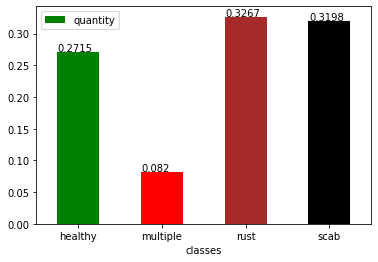

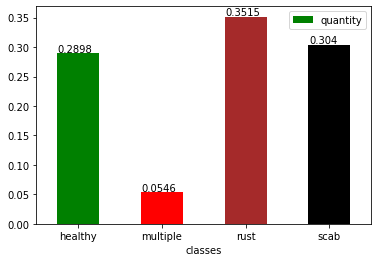

In [7]:


df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_train})
ax1 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
fig1 = ax1.get_figure()
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height() * 1.005))

df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_test})
ax2 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
fig2 = ax2.get_figure()

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.006))

fig1.savefig('train_repartition.png', dpi=400)
fig2.savefig('test_repartition.png', dpi=400)



print("Size of the training dataset :" + str(train_size))
print("Size of the testing dataset :" + str(test_size))

# Processing


## Importing useful functions from TDs

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




import torch.nn as nn
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          loss+= criterion(outputs, labels).item()
          _, predicted = torch.max(outputs.data, 1)
          #print(outputs, labels)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # if total > 100:
            # break
  net.train()
  return (100.0 * correct / total, loss/total)
  #return 100.0 * correct/tota

def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  acc_test = []
  acc_train = []
  total = 0
  min_loss = 0
  best_state = net.state_dict()
  for epoch in tqdm.tqdm(range(n_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)
          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            # break
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          acc_test.append(cur_acc)
          loss_test.append(cur_loss)
          if(cur_loss < min_loss):
            min_loss = cur_loss
            best_state = net.state_dict()
          print("Testing set :")
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))

          # training set
          print("Training set :")
          cur_acc, cur_loss = accuracy(net, train_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
          print(" ")
          acc_train.append(cur_acc)
          loss_train.append(cur_loss)
      
  print('Finished Training')
  return (loss_train, acc_train,loss_test, acc_test, min_loss, best_state)

In [9]:
# confusion matrix
import seaborn as sn
import pandas as pd
def confusion_matrix(model, dataloader, size = 4, name = "Test", cuda = True, index = ['healthy', 'multiple', 'rust', 'scab']): # here there are four classe
  model.eval()
  mat = np.zeros((size,size))
  total = 0
  corr = 0
  qty = [0]*size
  for images, labels in dataloader:
    
    if cuda:
      images = images.type(torch.cuda.FloatTensor)
      labels = labels.type(torch.cuda.LongTensor)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
     # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
      if(labels[k].item() == predicted[k].item()):
        corr +=1
      mat[labels[k].item(),predicted[k].item()]+=1
      qty[labels[k].item()]+=1
  for k in range(size):
    mat[k] *= 1/qty[k]
   # mat[k][size] = qty[k]/total # to have the total of images that the given class represented in the testing dataset
  model.train()
  dataframe = pd.DataFrame(mat, index=index)

  ax = plt.axes()

  svm = sn.heatmap(dataframe, annot=True, ax= ax)
  ax.set_title('Accuracy ' + name + " : " + str(round(corr / total,3)))
  figure = svm.get_figure()    
  figure.savefig('conf_mat' + name +'.png', dpi=400)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# plotting results
def plot(name ,title, Y_test = None, Y_train = None, log_scale = True ):
  if(Y_test != None):
    n = len(Y_test)
    X = np.linspace(1,n,n)
    plt.plot(X,Y_test, label = "test", color = "b")
    if(Y_train != None):
      plt.plot(X,Y_train, label = "train", color = "r")
  else :
    if(Y_train != None):
      n = len(Y_train)
      X = np.linspace(1,n,n)
      plt.plot(X,Y_train, label = "train", color = "r")
    else :
      return "ERROR : both given lists are None object. "
  
  plt.legend(loc='best')
  plt.title(title)
  if(log_scale):
    plt.yscale("log")
  plt.savefig(name, dpi = 400)
  plt.show()

## Importing model

In [0]:
model=torchvision.models.resnet50(pretrained=True)


In [0]:
k = 0
for child in model.children() :
  k+=1
number_of_blocs = k

In [0]:
k = 0
for param in model.parameters():
  k+=1

number_of_layers = k

In [14]:
print(" There are " + str(number_of_blocs) + " blocs in this net for a total of " + str(number_of_layers) + " layers.")

 There are 10 blocs in this net for a total of 161 layers.


In [15]:
# custom function to freeze wanted layer 
# here 10 means that the classifier is not freeze
k = 0
freeze_layers = 10
for child in model.children():
  k += 1
  if(k < freeze_layers ):
    for param in child.parameters():
      param.requires_grad = False
  else : 
    param.requires_grad = True

    print(child)
    print("was not freezed.")

Linear(in_features=2048, out_features=1000, bias=True)
was not freezed.


In [0]:
# 3 classes first
lin = model.fc

new_lin = nn.Sequential(
    lin,
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(lin.out_features, 3),
)

model.fc = new_lin

## Training - 1st phase

In [0]:
model = model.cuda()

In [18]:
lr = 5e-4

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9, 0.999),eps=1e-8)

batch_size = 64
epochs = 10
testloader = torch.utils.data.DataLoader(testing_set_3classes, 1, shuffle=False)
trainloader = torch.utils.data.DataLoader(training_set_3classes, batch_size, shuffle=True)
loss_train_, acc_train_,loss_test_, acc_test_, min_loss, best_state= train(model, opt, trainloader, testloader, criterion, n_epoch = epochs, train_acc_period = 10000,
          test_acc_period = 1)



  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the test images: 86 %
[1] loss: 0.382
[1] acc: 86.683


 10%|█         | 1/10 [00:17<02:38, 17.56s/it]

Accuracy of the network on the test images: 88 %
Accuracy of the network on the test images: 85 %
[2] loss: 0.345
[2] acc: 85.427


 20%|██        | 2/10 [00:34<02:19, 17.50s/it]

Accuracy of the network on the test images: 90 %
Accuracy of the network on the test images: 82 %
[3] loss: 0.454
[3] acc: 82.663


 30%|███       | 3/10 [00:52<02:02, 17.44s/it]

Accuracy of the network on the test images: 86 %
Accuracy of the network on the test images: 87 %
[4] loss: 0.313
[4] acc: 87.437


 40%|████      | 4/10 [01:09<01:44, 17.40s/it]

Accuracy of the network on the test images: 91 %
Accuracy of the network on the test images: 89 %
[5] loss: 0.346
[5] acc: 89.698


 50%|█████     | 5/10 [01:26<01:26, 17.38s/it]

Accuracy of the network on the test images: 90 %
Accuracy of the network on the test images: 88 %
[6] loss: 0.299
[6] acc: 88.191


 60%|██████    | 6/10 [01:44<01:09, 17.37s/it]

Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 85 %
[7] loss: 0.342
[7] acc: 85.930


 70%|███████   | 7/10 [02:01<00:52, 17.37s/it]

Accuracy of the network on the test images: 91 %
Accuracy of the network on the test images: 89 %
[8] loss: 0.327
[8] acc: 89.698


 80%|████████  | 8/10 [02:18<00:34, 17.36s/it]

Accuracy of the network on the test images: 93 %
Accuracy of the network on the test images: 89 %
[9] loss: 0.314
[9] acc: 89.447


 90%|█████████ | 9/10 [02:36<00:17, 17.36s/it]

Accuracy of the network on the test images: 94 %
Accuracy of the network on the test images: 87 %
[10] loss: 0.314
[10] acc: 87.688


100%|██████████| 10/10 [02:53<00:00, 17.36s/it]

Accuracy of the network on the test images: 95 %
Finished Training


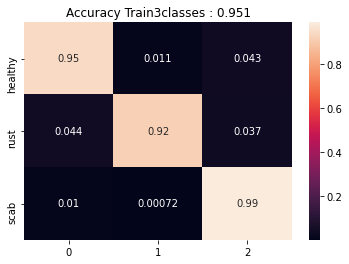

In [19]:
confusion_matrix(model, trainloader, size=3, name  = "Train3classes", index = ['healthy', 'rust', 'scab'])

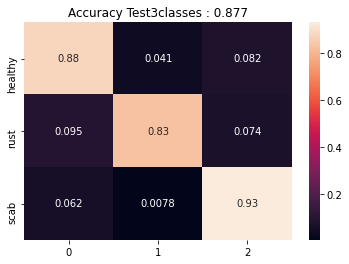

In [20]:
confusion_matrix(model, testloader, size=3, name  = "Test3classes", index = ['healthy', 'rust', 'scab'])

In [0]:
torch.save(model, "model3classes")

## New layer ...

In [0]:

lin = model.fc

alpha1 = 0.75
alpha2 = 0.75

new_lin = nn.Sequential(
    lin,
    nn.ReLU(),
    nn.Linear(3, 4),
)

model.fc = new_lin

In [23]:
# to initialize the new layers weights
rank = 3
def init_last(model):
  model.eval()
  count = 0
  for param in model.fc : 
    count +=1
    if(count == rank):
      with torch.no_grad():
        alpha1 = 1.01
        alpha2 = 1.01
        alpha = 1/np.sqrt(3)
        for i in range(4):
          # giving weights could work for the last layer
          for j in range(3):
            param.weight[i][j] = 0
        param.weight[0][0] = alpha
        param.weight[2][1] = alpha
        param.weight[3][2] = alpha
        param.weight[1][2] = alpha1*alpha
        param.weight[1][1] = alpha2*alpha
        param.bias[0] = 0
        param.bias[1] = 0
        param.bias[2] = 0
        param.bias[3] = 0

        print(param.weight)
  model.train()

def print_last(model):
  model.eval()
  count = 0
  for param in model.fc : 
    count +=1
    if(count == rank):
      print(param.weight)
  model.train()

init_last(model)
print_last(model)
loss_train, acc_train,loss_test, acc_test = [],[],[],[]

Parameter containing:
tensor([[0.5774, 0.0000, 0.0000],
        [0.0000, 0.5831, 0.5831],
        [0.0000, 0.5774, 0.0000],
        [0.0000, 0.0000, 0.5774]], requires_grad=True)
Parameter containing:
tensor([[0.5774, 0.0000, 0.0000],
        [0.0000, 0.5831, 0.5831],
        [0.0000, 0.5774, 0.0000],
        [0.0000, 0.0000, 0.5774]], requires_grad=True)


In [0]:
k = 0
for child in model.children() :
  k+=1
number_of_blocs = k

In [0]:
k = 0
for param in model.parameters():
  k+=1

number_of_layers = k

In [26]:
print(" There are " + str(number_of_blocs) + " blocs in this net for a total of " + str(number_of_layers) + " layers.")

 There are 10 blocs in this net for a total of 165 layers.


In [45]:
# then we freeze the layers before the last one 
k = 0
freeze_layers = 10
freeze_param = 1 # 2 to freeze everyting except the lass layer 3-4,  1 to freeze the first layer of the classifier - 0 to unfreeze everything
for child in model.children():
  k += 1
  if(k < freeze_layers ):
    for param in child.parameters():
      param.requires_grad = False
  else :
    count = 0
    print(child)
    for param in child.parameters():
      if(count == 2):
        param.requires_grad = True
      if(count > freeze_param):
        param.requires_grad = True
        print(param)
        print("was not freezed.")
      else:
        param.requires_grad = False
      count+=1

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1000, out_features=3, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=3, out_features=4, bias=True)
)
Parameter containing:
tensor([[-0.0147, -0.0104, -0.0201,  ...,  0.0033, -0.0041, -0.0208],
        [-0.0248,  0.0251,  0.0030,  ...,  0.0245, -0.0124,  0.0061],
        [-0.0249,  0.0046, -0.0005,  ...,  0.0146,  0.0272,  0.0180]],
       device='cuda:0', requires_grad=True)
was not freezed.
Parameter containing:
tensor([-0.0032,  0.0408, -0.0077], device='cuda:0', requires_grad=True)
was not freezed.
Parameter containing:
tensor([[ 0.5820, -0.0231, -0.0209],
        [ 0.0132,  0.5701,  0.5827],
        [-0.0220,  0.5967, -0.0227],
        [-0.0227, -0.0240,  0.5893]], device='cuda:0', requires_grad=True)
was not freezed.
Parameter containing:
tensor([-0.0128,  0.0146,  0.0020, -0.0167], device='cuda:0'

In [0]:
model = model.cuda()

L'apprentissage réalisée en dessous a été fait pour uniquement la couche 3->4 (la dernière) de dégelé. 
Elle devrait être suivie lorsque la précision stagne d'un dégelage de la couche précédente, et lorsque celle-ci stagne encore, un dégelage de tout le classifieur. Attention cependant au sur-apprentissagge... (cf. plus haut pour dégeler ces couches).

L'entrainement de ce modèle nécessite une certaine finesse et une progression pas à pas sous risque de tomber très rapidement dans l'ignorance complète du la classe 1.


In [54]:
lr = 1e-5 # shound not be too large, otherwise there is a risk of ignoring the class "multiple diseases"

class_weights = torch.FloatTensor([1, 8, 1, 1]).cuda() # 8 : to be sure that we are not going to ignore it

criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9, 0.999),eps=1e-8)

batch_size = 64
epochs = 3
testloader = torch.utils.data.DataLoader(testing_set, 1, shuffle=False)
trainloader = torch.utils.data.DataLoader(training_set, batch_size, shuffle=True)
loss_train_, acc_train_,loss_test_, acc_test_, min_loss, best_state= train(model, opt, trainloader, testloader, criterion, n_epoch = epochs, train_acc_period = 10000,
          test_acc_period = 1)





  0%|          | 0/3 [00:00<?, ?it/s]

Testing set :
[1] loss: 0.838
[1] acc: 69.834
Training set :




 33%|███▎      | 1/3 [00:24<00:48, 24.10s/it]

[1] loss: 0.013
[1] acc: 72.881
Testing set :
[2] loss: 0.850
[2] acc: 68.884
Training set :




 67%|██████▋   | 2/3 [00:48<00:24, 24.09s/it]

[2] loss: 0.013
[2] acc: 73.294
Testing set :
[3] loss: 0.847
[3] acc: 69.121
Training set :




100%|██████████| 3/3 [01:12<00:00, 24.08s/it]

[3] loss: 0.013
[3] acc: 73.001
Finished Training


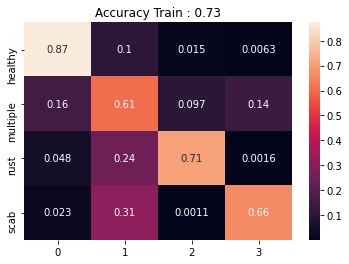

In [55]:
confusion_matrix(model, trainloader, name  = "Train")


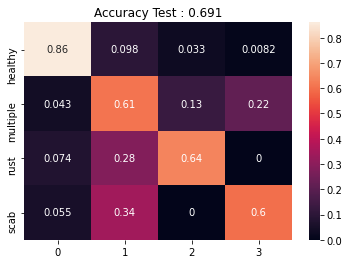

In [56]:
confusion_matrix(model, testloader)